# Overview
The notebook shows how the ```lime_image``` tools can be applied to a slightly larger dataset like the Olivetti Faces. The dataset is very low resolution and allows quite a bit of rapid-iteration.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import gray2rgb, rgb2gray # since the code wants color images
from skimage.util import montage as montage2d


In [3]:
from sklearn.datasets import fetch_olivetti_faces
faces = fetch_olivetti_faces()
# make each image color so lime_image works correctly
X_vec = np.stack([gray2rgb(iimg) for iimg in faces.data.reshape((-1, 64, 64))],0)
y_vec = faces.target.astype(np.uint8)

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to C:\Users\Parth.chokhra\scikit_learn_data


(-0.5, 1279.5, 1279.5, -0.5)

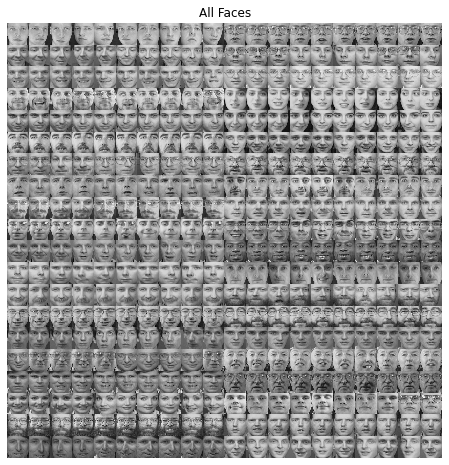

In [4]:
%matplotlib inline
fig, ax1 = plt.subplots(1,1, figsize = (8,8))
ax1.imshow(montage2d(X_vec[:,:,:,0]), cmap='gray', interpolation = 'none')
ax1.set_title('All Faces')
ax1.axis('off')

# Setup a Pipeline
Here we make a pipeline for processing the images where basically we flatten the image back to 1d vectors and then use a RandomForest Classifier

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA

class PipeStep(object):
    """
    Wrapper for turning functions into pipeline transforms (no-fitting)
    """
    def __init__(self, step_func):
        self._step_func=step_func
    def fit(self,*args):
        return self
    def transform(self,X):
        return self._step_func(X)

makegray_step = PipeStep(lambda img_list: [rgb2gray(img) for img in img_list])
flatten_step = PipeStep(lambda img_list: [img.ravel() for img in img_list])

simple_rf_pipeline = Pipeline([
    ('Make Gray', makegray_step),
    ('Flatten Image', flatten_step),
    ('Normalize', Normalizer()),
    ('PCA', PCA(25)),
    ('XGBoost', GradientBoostingClassifier())
                              ])

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_vec, y_vec,
                                                    train_size=0.70)

In [7]:
simple_rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('Make Gray', <__main__.PipeStep object at 0x00000198F12284C8>),
                ('Flatten Image',
                 <__main__.PipeStep object at 0x00000198F1228488>),
                ('Normalize', Normalizer()), ('PCA', PCA(n_components=25)),
                ('XGBoost', GradientBoostingClassifier())])

# Scoring the Model
We show the scoring of the model on the test data to see how well it works


In [8]:
# compute on remaining test data
pipe_pred_test = simple_rf_pipeline.predict(X_test)
pipe_pred_prop = simple_rf_pipeline.predict_proba(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_true=y_test, y_pred = pipe_pred_test))

              precision    recall  f1-score   support

           0       0.29      0.67      0.40         3
           1       0.50      0.50      0.50         2
           2       0.00      0.00      0.00         1
           3       0.50      0.67      0.57         3
           4       0.67      0.40      0.50         5
           5       0.67      0.80      0.73         5
           6       0.00      0.00      0.00         0
           7       1.00      0.25      0.40         4
           8       0.67      0.67      0.67         3
           9       0.67      0.67      0.67         3
          10       1.00      0.33      0.50         3
          11       1.00      0.67      0.80         3
          12       0.30      1.00      0.46         3
          13       0.50      1.00      0.67         2
          14       0.33      0.50      0.40         2
          15       0.29      0.67      0.40         3
          16       0.00      0.00      0.00         1
          17       0.67    

c:\Users\Parth.chokhra\Miniconda3\envs\workflowone\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Parth.chokhra\Miniconda3\envs\workflowone\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Parth.chokhra\Miniconda3\envs\workflowone\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start

In [9]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime

In [12]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
explainer = lime_image.LimeImageExplainer(verbose = False)
segmenter = SegmentationAlgorithm('slic', n_segments=100, compactness=1, sigma=1)

c:\Users\Parth.chokhra\Miniconda3\envs\workflowone\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
%%time
explanation = explainer.explain_instance(X_test[0], 
                                         classifier_fn = simple_rf_pipeline.predict_proba, 
                                         top_labels=6, hide_color=0, num_samples=10000, segmentation_fn=segmenter)

100%|██████████| 10000/10000 [00:07<00:00, 1382.70it/s]


Wall time: 7.48 s


Text(0.5, 1.0, 'Positive/Negative Regions for 14')

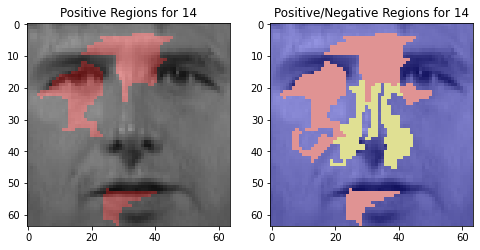

In [20]:
from skimage.color import label2rgb
temp, mask = explanation.get_image_and_mask(y_test[0], positive_only=True, num_features=5, hide_rest=False)
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
ax1.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
ax1.set_title('Positive Regions for {}'.format(y_test[0]))
temp, mask = explanation.get_image_and_mask(y_test[0], positive_only=False, num_features=10, hide_rest=False)
ax2.imshow(label2rgb(3-mask,temp, bg_label = 0), interpolation = 'nearest')
ax2.set_title('Positive/Negative Regions for {}'.format(y_test[0]))

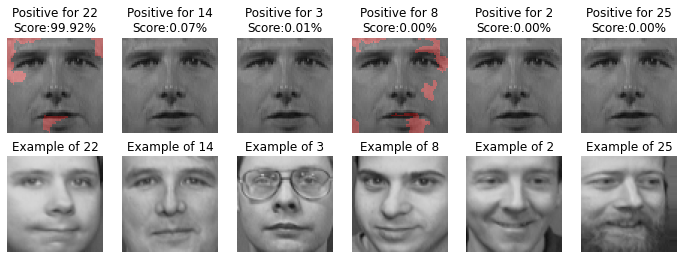

In [21]:
# now show them for each class
fig, m_axs = plt.subplots(2,6, figsize = (12,4))
for i, (c_ax, gt_ax) in zip(explanation.top_labels, m_axs.T):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=5, hide_rest=False, min_weight=0.01)
    c_ax.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
    c_ax.set_title('Positive for {}\nScore:{:2.2f}%'.format(i, 100*pipe_pred_prop[0, i]))
    c_ax.axis('off')
    face_id = np.random.choice(np.where(y_train==i)[0])
    gt_ax.imshow(X_train[face_id])
    gt_ax.set_title('Example of {}'.format(i))
    gt_ax.axis('off')

# Gaining Insight
Can we find an explanation for a classification the algorithm got wrong

In [22]:
wrong_idx = np.random.choice(np.where(pipe_pred_test!=y_test)[0])

print('Using #{} where the label was {} and the pipeline predicted {}'.format(wrong_idx, y_test[wrong_idx], pipe_pred_test[wrong_idx]))

Using #3 where the label was 30 and the pipeline predicted 12


In [23]:
%%time
explanation = explainer.explain_instance(X_test[wrong_idx], 
                                         classifier_fn = simple_rf_pipeline.predict_proba, 
                                         top_labels=6, hide_color=0, num_samples=10000, segmentation_fn=segmenter)

100%|██████████| 10000/10000 [00:06<00:00, 1462.29it/s]


Wall time: 7.1 s


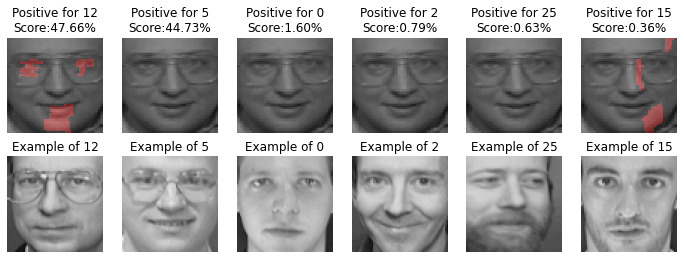

In [24]:
# now show them for each class
fig, m_axs = plt.subplots(2,6, figsize = (12,4))
for i, (c_ax, gt_ax) in zip(explanation.top_labels, m_axs.T):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=5, hide_rest=False, min_weight=0.01)
    c_ax.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
    c_ax.set_title('Positive for {}\nScore:{:2.2f}%'.format(i, 100*pipe_pred_prop[wrong_idx, i]))
    c_ax.axis('off')
    face_id = np.random.choice(np.where(y_train==i)[0])
    gt_ax.imshow(X_train[face_id])
    gt_ax.set_title('Example of {}'.format(i))
    gt_ax.axis('off')